# MLflow quickstart: training and logging  

This tutorial is based on the MLflow [ElasticNet Diabetes example](https://github.com/mlflow/mlflow/tree/master/examples/sklearn_elasticnet_diabetes). It illustrates how to use MLflow to track the model training process, including logging model parameters, metrics, the model itself, and other artifacts like plots. It also includes instructions for viewing the logged results in the MLflow tracking UI.    

This notebook uses the scikit-learn `diabetes` dataset and predicts the progression metric (a quantitative measure of disease progression after one year) based on BMI, blood pressure, and other measurements. It uses the scikit-learn ElasticNet linear regression model, varying the `alpha` and `l1_ratio` parameters for tuning. For more information on ElasticNet, refer to:
  * [Elastic net regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization)
  * [Regularization and Variable Selection via the Elastic Net](https://web.stanford.edu/~hastie/TALKS/enet_talk.pdf)
  
## Requirements
* This notebook requires Databricks Runtime 6.4 or above, or Databricks Runtime 6.4 ML or above. You can also use a Python 3 cluster running Databricks Runtime 5.5 LTS or Databricks Runtime 5.5 LTS ML.
* If you are using a cluster running Databricks Runtime, you must install MLflow. See "Install a library on a cluster" ([AWS](https://docs.databricks.com/libraries/cluster-libraries.html#install-a-library-on-a-cluster)|[Azure](https://docs.microsoft.com/azure/databricks/libraries/cluster-libraries#--install-a-library-on-a-cluster)|[GCP](https://docs.gcp.databricks.com/libraries/cluster-libraries.html#install-a-library-on-a-cluster)). Select **Library Source** PyPI and enter `mlflow` in the **Package** field.
* If you are using a cluster running Databricks Runtime ML, MLflow is already installed.

### Note
This notebook expects that you use a Databricks hosted MLflow tracking server. If you would like to preview the Databricks MLflow tracking server, contact your Databricks sales representative to request access. To set up your own tracking server, see the instructions in MLflow [Tracking Servers](https://www.mlflow.org/docs/latest/tracking.html#mlflow-tracking-servers) and configure your connection to your tracking server by running [mlflow.set_tracking_uri](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_tracking_uri).

## Import required libraries and load dataset

In [0]:
#pip install mlflow

In [0]:
# Import required libraries
import os
import warnings
import sys

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

# Import mlflow
import mlflow
import mlflow.sklearn

# Load diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

# Create pandas DataFrame 
Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']
data = pd.DataFrame(d, columns=cols)

## Create function to plot ElasticNet descent path
The `plot_enet_descent_path()` function:
* Creates and saves a plot of the [ElasticNet Descent Path](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html) for the ElasticNet model for the specified *l1_ratio*.
* Returns an image that can be displayed in the notebook using `display()`
* Saves the figure `ElasticNet-paths.png` to the cluster driver node

In [0]:
def plot_enet_descent_path(X, y, l1_ratio):
    # Compute paths
    eps = 5e-3  # the smaller it is the longer is the path

    # Reference the global image variable
    global image
    
    print("Computing regularization path using ElasticNet.")
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)

    # Display results
    fig = plt.figure(1)
    ax = plt.gca()

    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_enet = -np.log10(alphas_enet)
    for coef_e, c in zip(coefs_enet, colors):
        l1 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
    plt.title(title)
    plt.axis('tight')

    # Display images
    image = fig
    
    # Save figure
    fig.savefig("ElasticNet-paths.png")

    # Close plot
    plt.close(fig)

    # Return images
    return image    

## Train the diabetes model
The `train_diabetes()` function trains ElasticNet linear regression based on the input parameters *in_alpha* and *in_l1_ratio*.

The function uses MLflow Tracking to record the following:
* parameters
* metrics
* model
* the image created by the `plot_enet_descent_path()` function defined previously.

**Tip:** Databricks recommends using `with mlflow.start_run:` to create a new MLflow run. The `with` context closes the MLflow run regardless of whether the code completes successfully or exits with an error, and you do not have to call `mlflow.end_run`.

In [0]:
# train_diabetes
#   Uses the sklearn Diabetes dataset to predict diabetes progression using ElasticNet
#       The predicted "progression" column is a quantitative measure of disease progression one year after baseline
#       http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
def train_diabetes(data, in_alpha, in_l1_ratio):
  
  # Evaluate metrics
  def eval_metrics(actual, pred):
      rmse = np.sqrt(mean_squared_error(actual, pred))
      mae = mean_absolute_error(actual, pred)
      r2 = r2_score(actual, pred)
      return rmse, mae, r2

  warnings.filterwarnings("ignore")
  np.random.seed(40)

  # Split the data into training and test sets. (0.75, 0.25) split.
  train, test = train_test_split(data)

  # The predicted column is "progression" which is a quantitative measure of disease progression one year after baseline
  train_x = train.drop(["progression"], axis=1)
  test_x = test.drop(["progression"], axis=1)
  train_y = train[["progression"]]
  test_y = test[["progression"]]

  if float(in_alpha) is None:
    alpha = 0.05
  else:
    alpha = float(in_alpha)
    
  if float(in_l1_ratio) is None:
    l1_ratio = 0.05
  else:
    l1_ratio = float(in_l1_ratio)
  
  # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
  with mlflow.start_run():
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    # Print out ElasticNet model metrics
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    # Log mlflow attributes for mlflow UI
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(lr, "model")
    modelpath = "/dbfs/mlflow/test_diabetes/model-%f-%f" % (alpha, l1_ratio)
    mlflow.sklearn.save_model(lr, modelpath)
    
    # Call plot_enet_descent_path
    image = plot_enet_descent_path(X, y, l1_ratio)
    
    # Log artifacts (output files)
    mlflow.log_artifact("ElasticNet-paths.png")

## Experiment with different parameters

Call `train_diabetes` with different parameters. You can visualize all these runs in the MLflow experiment.

In [0]:
%fs rm -r dbfs:/mlflow/test_diabetes

res0: Boolean = false

In [0]:
# alpha and l1_ratio values of 0.01, 0.01
train_diabetes(data, 0.1, 0.01)

Elasticnet model (alpha=0.100000, l1_ratio=0.010000):
 RMSE: 80.45400860425543
 MAE: 68.00727420927113
 R2: 0.02130914220674318
Computing regularization path using ElasticNet.

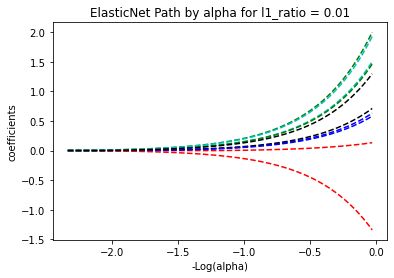

In [0]:
display(image)

In [0]:
# alpha and l1_ratio values of 0.01, 0.75
train_diabetes(data, 0.01, 0.75)

Elasticnet model (alpha=0.010000, l1_ratio=0.750000):
 RMSE: 65.28994906390733
 MAE: 53.75914828434926
 R2: 0.35547047607749416
Computing regularization path using ElasticNet.

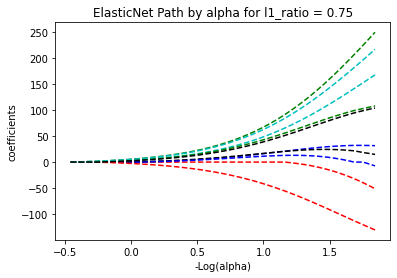

In [0]:
display(image)

In [0]:
# alpha and l1_ratio values of 0.01, .5
train_diabetes(data, 0.01, .5)

Elasticnet model (alpha=0.010000, l1_ratio=0.500000):
 RMSE: 67.98354871814037
 MAE: 56.73838604280737
 R2: 0.30119208073981796
Computing regularization path using ElasticNet.

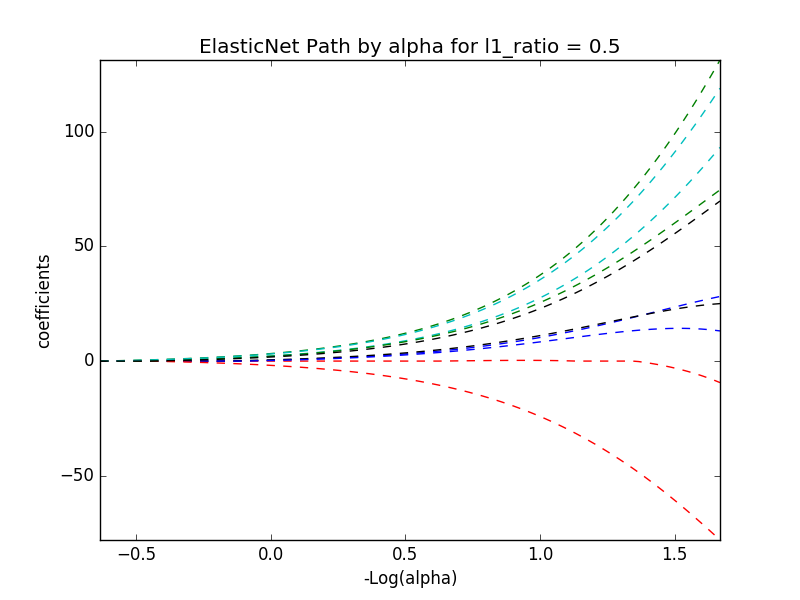

In [0]:
display(image)

In [0]:
# alpha and l1_ratio values of 0.01, 1
train_diabetes(data, 0.01, 1)

Elasticnet model (alpha=0.010000, l1_ratio=1.000000):
 RMSE: 63.24666777876805
 MAE: 51.05182860408632
 R2: 0.3951809598912357
Computing regularization path using ElasticNet.

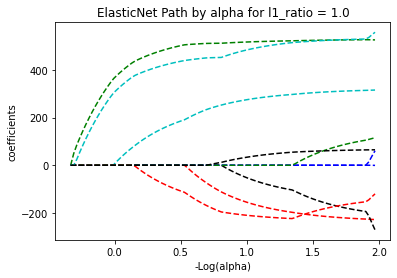

In [0]:
display(image)

## View the experiment, run, and notebook revision in the MLflow UI
To view the results, click **Experiment** at the upper right of this page. The Experiments sidebar appears. This sidebar displays the parameters and metrics for each run of this notebook. Click the circular arrows icon to refresh the display to include the latest runs. 

To view the notebook experiment, which contains a list of runs with their parameters and metrics, click the square icon with the arrow to the right of **Experiment Runs**. The Experiment page displays in a new tab. The **Source** column in the table contains a link to the notebook revision associated with each run.

To view the details of a particular run, click the link in the **Start Time** column for that run. Or, in the Experiments sidebar, click the icon at the far right of the date and time of the run. 

For more information, see "View notebook experiment" ([AWS](https://docs.databricks.com/applications/mlflow/tracking.html#view-notebook-experiment)|[Azure](https://docs.microsoft.com/azure/databricks/applications/mlflow/tracking#view-notebook-experiment)|[GCP](https://docs.gcp.databricks.com/applications/mlflow/tracking.html#view-notebook-experiment)).